<a href="https://colab.research.google.com/github/Aesol-Ahn/DA_Exercise/blob/master/1127%EA%B0%90%EC%84%B1_%EB%B6%84%EB%A5%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#biLSTM 기반 감성 분류기

In [3]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 70.4MB/s 
     |████████████████████████████████| 92kB 11.4MB/s 
     |████████████████████████████████| 460kB 50.3MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")


('steam.txt', <http.client.HTTPMessage at 0x7f562f1f7668>)

In [7]:
#https://github.com/bab2min/corpus/tree/master/sentiment
#감성 분석용 말뭉치 깃허브 주소

In [8]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data))


전체 리뷰 개수 : 100000


In [9]:
total_data['reviews'].nunique()

99892

In [10]:
total_data['label'].nunique()

2

In [16]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)

In [17]:
print('총 샘플의 수 : ', len(total_data))

총 샘플의 수 :  99892


In [18]:
print(total_data.isnull().values.any())

False


In [19]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))


훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


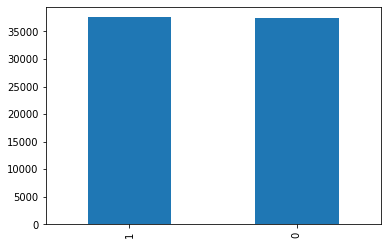

In [20]:
train_data['label'].value_counts().plot(kind = 'bar')


In [57]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
train_data['reviews'].replace('', np.nan, inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [59]:
print(train_data.isnull().sum())


label        0
reviews      0
tokenized    0
dtype: int64


In [60]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))


전처리 후 테스트용 샘플의 개수 : 24921


In [61]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']


In [62]:
okt=Okt()

In [63]:
train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [64]:
#okt의 morphs:형태소 단위로 나누어 주는 작업 수행
# :reviews라는 열에 대해서 형태소 단위로 나누어라, 이것을 tokenized 열에 추가해라
#lambda 함수: tokenized x에 대해서 item 변수에 담았을 때 item이 스탑워즈에 있지 않다면 적용 

In [65]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)


In [66]:
#hstack(두개의 배열을 좌우로 합칠 때 사용하는 함수) vs. vstack(두개의배열을 위아래로 합칠 때 사용)

In [67]:
#train_data.head()

In [68]:
#train_data[train_data.label == 0]
#train_data[train_data.label == 0]['tokenized']
#train_data[train_data.label == 0]['tokenized'].values

#np.hstack(train_data[train_data.label == 0]['tokenized'].values)

In [69]:
#counter 클래스 import한거 이용해서 

In [70]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))


[('안', 4027), ('로', 3732), ('너무', 3475), ('못', 3068), ('으로', 3043), ('하고', 2552), ('할', 2388), ('개', 2267), ('시간', 2204), ('그냥', 2155), ('거', 2151), ('적', 2151), ('하는', 2119), ('왜', 2043), ('에서', 2033), ('것', 2008), ('플레이', 2007), ('나', 1923), ('좀', 1921), ('사람', 1813)]


In [71]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))


[('로', 3545), ('으로', 3454), ('할', 2711), ('플레이', 2690), ('시간', 2382), ('입니다', 2372), ('적', 2365), ('것', 2346), ('때', 2273), ('하는', 2260), ('너무', 2251), ('추천', 2239), ('좀', 2172), ('갓', 2118), ('안', 2078), ('수', 2024), ('하고', 2006), ('에서', 1904), ('하면', 1862), ('스토리', 1829)]


긍정 리뷰의 평균 길이 : 13.172255813334043
부정 리뷰의 평균 길이 : 13.564854452054794


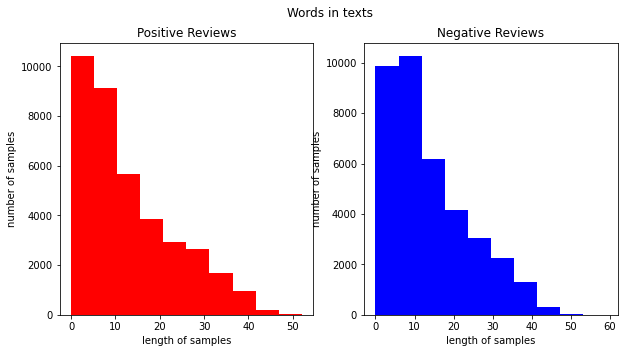

In [72]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()


In [73]:
#리뷰는 자연어로 들어오니까 토큰화진행해야하고 토큰화는 연산을 위해 숫자로 바꾸어 줘야 한다. 근데 단어가 너무많음... so, 단어 빈도수 낮은 애들은 oov로 처리(버린다)

In [74]:
X_train = train_data['tokenized'].values 
#array로 바꾸는 이유: 모델에 입력되는건 list가 아닌 array


In [75]:
Y_train = train_data['label'].values

In [76]:
X_test= test_data['tokenized'].values
Y_test = test_data['label'].values


In [94]:
tokenizer = Tokenizer(10)
tokenizer.fit_on_texts(X_train)


In [95]:
tokenizer.index_word

{1: '로',
 2: '으로',
 3: '안',
 4: '너무',
 5: '할',
 6: '플레이',
 7: '시간',
 8: '하고',
 9: '못',
 10: '적',
 11: '하는',
 12: '것',
 13: '좀',
 14: '에서',
 15: '때',
 16: '입니다',
 17: '추천',
 18: '나',
 19: '사람',
 20: '재미',
 21: '거',
 22: '개',
 23: '스토리',
 24: '하면',
 25: '그냥',
 26: '더',
 27: '생각',
 28: '내',
 29: '잘',
 30: '수',
 31: '왜',
 32: '진짜',
 33: '갓',
 34: '그',
 35: '이다',
 36: '정말',
 37: '아',
 38: '보다',
 39: '함',
 40: '버그',
 41: '같은',
 42: '그래픽',
 43: '돈',
 44: '정도',
 45: '요',
 46: '합니다',
 47: '해서',
 48: '분',
 49: '뭐',
 50: '친구',
 51: '중',
 52: '인데',
 53: '있는',
 54: '환불',
 55: '하지만',
 56: '느낌',
 57: '처음',
 58: '까지',
 59: '일',
 60: '하나',
 61: '멀티',
 62: '말',
 63: '좋은',
 64: '감',
 65: '난이도',
 66: '걸',
 67: '구매',
 68: '저',
 69: '했는데',
 70: '많이',
 71: '엔딩',
 72: '없는',
 73: '실행',
 74: '해',
 75: '서',
 76: '랑',
 77: '서버',
 78: '때문',
 79: '그리고',
 80: '없다',
 81: '세',
 82: '하지',
 83: '퍼즐',
 84: '다시',
 85: '무료',
 86: '없음',
 87: '시작',
 88: '점',
 89: '계속',
 90: '키',
 91: '근데',
 92: '이런',
 93: '도전',
 94: '조작',
 9

In [96]:
tokenizer.word_counts

OrderedDict([('클리어', 585),
             ('할', 5099),
             ('때', 3884),
             ('까지', 1718),
             ('계속', 1330),
             ('새', 249),
             ('롭고', 72),
             ('질리', 138),
             ('않습니다', 344),
             ('정말', 2550),
             ('잘', 2968),
             ('만든', 525),
             ('퍼즐', 1382),
             ('입니다', 3634),
             ('추천', 3579),
             ('합니다', 2182),
             ('편', 806),
             ('나름', 640),
             ('재밌게', 994),
             ('했으면', 155),
             ('그', 2649),
             ('걸', 1557),
             ('로', 7277),
             ('멈추는게', 4),
             ('좋았네', 1),
             ('할거', 216),
             ('드럽게', 97),
             ('없음', 1350),
             ('ㅈ', 619),
             ('까라', 9),
             ('이건', 966),
             ('그거', 256),
             ('하나', 1682),
             ('만으로도', 70),
             ('살', 473),
             ('가치', 277),
             ('없는', 1486),
             ('내', 3105),
  

In [97]:
total_cnt = len(tokenizer.word_index) # 단어의 수

In [98]:
threshold = 2


In [99]:
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합


In [100]:
#tokenizer.word_counts #단어 빈도수 출력

for key, value in tokenizer.word_counts.items():
   total_freq = total_freq + value
   # 단어의 등장 빈도수가 threshold보다 작으면
   if(value < threshold):
      rare_cnt = rare_cnt + 1        #희귀 단어 카운트
      rare_freq = rare_freq + value  #희귀 단어 빈도수 누적



In [101]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 69561
등장 빈도가 1번 이하인 희귀 단어의 수: 37971
단어 집합에서 희귀 단어의 비율: 54.58662181394747
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7913144541429777


In [102]:
vocab_size = total_cnt - rare_cnt + 2

#0번은 패딩, 1번은 oov로 사용, 2번부터 실제 단어로 index 부여
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  31592


In [104]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV') 

#oov옵션으로 기타 단어는 1번에 몰아 넣을 수 있다.

In [105]:
tokenizer.fit_on_texts(X_train)

In [106]:
tokenizer.index_word

{1: 'OOV',
 2: '로',
 3: '으로',
 4: '안',
 5: '너무',
 6: '할',
 7: '플레이',
 8: '시간',
 9: '하고',
 10: '못',
 11: '적',
 12: '하는',
 13: '것',
 14: '좀',
 15: '에서',
 16: '때',
 17: '입니다',
 18: '추천',
 19: '나',
 20: '사람',
 21: '재미',
 22: '거',
 23: '개',
 24: '스토리',
 25: '하면',
 26: '그냥',
 27: '더',
 28: '생각',
 29: '내',
 30: '잘',
 31: '수',
 32: '왜',
 33: '진짜',
 34: '갓',
 35: '그',
 36: '이다',
 37: '정말',
 38: '아',
 39: '보다',
 40: '함',
 41: '버그',
 42: '같은',
 43: '그래픽',
 44: '돈',
 45: '정도',
 46: '요',
 47: '합니다',
 48: '해서',
 49: '분',
 50: '뭐',
 51: '친구',
 52: '중',
 53: '인데',
 54: '있는',
 55: '환불',
 56: '하지만',
 57: '느낌',
 58: '처음',
 59: '까지',
 60: '일',
 61: '하나',
 62: '멀티',
 63: '말',
 64: '좋은',
 65: '감',
 66: '난이도',
 67: '걸',
 68: '구매',
 69: '저',
 70: '했는데',
 71: '많이',
 72: '엔딩',
 73: '없는',
 74: '실행',
 75: '해',
 76: '서',
 77: '랑',
 78: '서버',
 79: '때문',
 80: '그리고',
 81: '없다',
 82: '세',
 83: '하지',
 84: '퍼즐',
 85: '다시',
 86: '무료',
 87: '없음',
 88: '시작',
 89: '점',
 90: '계속',
 91: '키',
 92: '근데',
 93: '이런',
 94: '도전',
 

In [109]:
#X_train[1] = 편, 나름, 재밌게, 했으면, 그, 걸, 로, 멈추는게, 좋았네
#             [173, 231, 135, 1038, 35, 67, 2, 15154, 1]
tokenizer.texts_to_sequences(X_train)

[[262, 6, 16, 59, 90, 656, 2017, 1151, 472, 37, 30, 298, 84, 17, 18, 47],
 [173, 231, 135, 1038, 35, 67, 2, 15154, 1],
 [748, 1593, 87],
 [245,
  9127,
  143,
  632,
  61,
  2063,
  341,
  586,
  73,
  29,
  69,
  22,
  79,
  168,
  216,
  116,
  162,
  2469,
  6785,
  168,
  49,
  59,
  299,
  2697,
  10,
  497,
  23,
  2018,
  249],
 [44, 906],
 [76,
  3287,
  71,
  10717,
  183,
  546,
  10718,
  679,
  2431,
  1306,
  164,
  78,
  87,
  198,
  4,
  8509,
  282,
  889,
  8510],
 [1242, 2244, 3, 13321, 5681, 1, 4185, 149, 7552],
 [3288, 100, 1039, 7, 117, 433, 425, 701, 1, 196, 1, 130, 500],
 [2064, 3354, 2470, 1, 416, 1, 6786, 2698, 416, 3, 2838],
 [608],
 [94,
  114,
  3892,
  3485,
  3,
  129,
  34,
  950,
  94,
  105,
  1558,
  1995,
  145,
  28,
  39,
  128,
  40,
  434,
  94,
  114,
  1471,
  233,
  13,
  7996],
 [230, 119, 15, 58, 3, 397, 53, 7137, 73, 153, 14],
 [84,
  6787,
  1,
  1197,
  10719,
  1472,
  202,
  25,
  107,
  406,
  115,
  5,
  22424,
  446,
  3,
  3724,
  17

In [110]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [111]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))

리뷰의 최대 길이 : 59


In [112]:
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 평균 길이 : 13.36811756697233


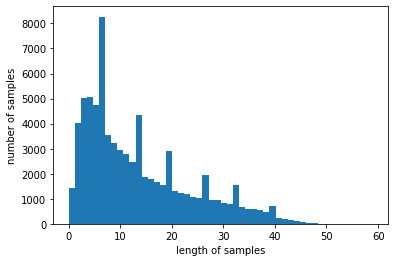

In [113]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [114]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))
max_len = 60
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 60 이하인 샘플의 비율: 100.0


In [115]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)


In [118]:
len(X_train[0])
#len(X_train[1])

60

In [117]:
X_train[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,   173,   231,   135,
        1038,    35,    67,     2, 15154,     1], dtype=int32)

In [119]:
# 여기까지 전처리 이제 끝남
# 트레이닝을 양방향으로 해서 긍정이냐 부정이냐 분류

In [120]:
import re
from keras.layers import Embedding, Dense, LSTM, Bidirectional
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [121]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))


In [122]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         3159200   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 3,320,201
Trainable params: 3,320,201
Non-trainable params: 0
_________________________________________________________________


In [123]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)


In [124]:
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


In [126]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)


Epoch 1/15
235/235 [==============================] - ETA: 0s - loss: 0.5189 - acc: 0.7438
Epoch 00001: val_acc improved from -inf to 0.78217, saving model to best_model.h5
235/235 [==============================] - 132s 562ms/step - loss: 0.5189 - acc: 0.7438 - val_loss: 0.4649 - val_acc: 0.7822
Epoch 2/15
235/235 [==============================] - ETA: 0s - loss: 0.4102 - acc: 0.8170
Epoch 00002: val_acc did not improve from 0.78217
235/235 [==============================] - 130s 555ms/step - loss: 0.4102 - acc: 0.8170 - val_loss: 0.5044 - val_acc: 0.7485
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.3742 - acc: 0.8354
Epoch 00003: val_acc improved from 0.78217 to 0.79064, saving model to best_model.h5
235/235 [==============================] - 130s 555ms/step - loss: 0.3742 - acc: 0.8354 - val_loss: 0.4574 - val_acc: 0.7906
Epoch 4/15
235/235 [==============================] - ETA: 0s - loss: 0.3483 - acc: 0.8494
Epoch 00004: val_acc did not improve from 0.

In [128]:
loaded_model = load_model('best_model.h5')
loaded_model.evaluate(X_test, Y_test)


779/779 [==============================] - 16s 21ms/step - loss: 0.4670 - acc: 0.7838


[0.46695268154144287, 0.783756673336029]

In [129]:

def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))



In [130]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

96.70% 확률로 부정 리뷰입니다.
